In [1]:
import pandas as pd
import matplotlib.pyplot as plt

p = plt.rcParams
p["font.sans-serif"] = ["Atkinson Hyperlegible"]
p["font.weight"] = "light"

In [2]:
df = pd.read_csv("../data/dsd-amsterdam-melody-decade-counts.csv")
df.head()

,melodieid,count,decade
0,2048,25,1600
1,2815,19,1600
2,1856,16,1600
3,3654,15,1600
4,2663,14,1600


In [3]:
from copia.data import to_copia_dataset

datasets = {}
for decade in df["decade"].unique():
    if decade >= 1700:
        continue
    ds = to_copia_dataset(df[df["decade"] == decade], input_type="counts",
                          index_column="melodieid", count_column="count")
    datasets[decade] = ds

In [4]:
from copia.rarefaction_extrapolation import species_accumulation

curves = {}
for decade, ds in datasets.items():
    curve = species_accumulation(ds, compute_coverage=True)
    curves[decade] = curve

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

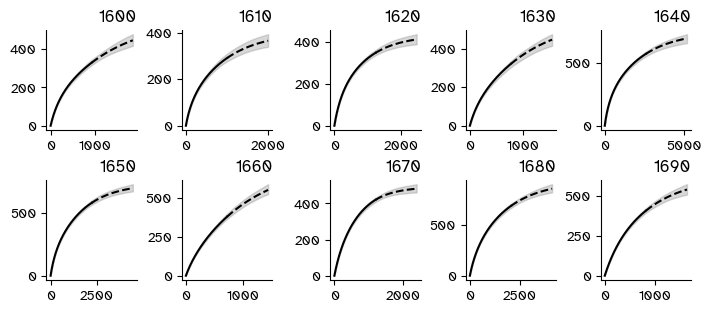

In [5]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(7, 3), constrained_layout=True)
axes = axes.flatten()

for ax in axes:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

ls = 'solid', 'dashed'

for i, decade in enumerate(curves.keys()):
    acc_df = curves[decade]
    estimation = acc_df['est'].values
    sample_size = acc_df.index
    interpolated = acc_df['interpolated'].values
    lci = acc_df['lci'].values
    uci = acc_df['uci'].values

    axes[i].plot(sample_size[interpolated], estimation[interpolated], color="black", ls="-")
    axes[i].plot(sample_size[~interpolated], estimation[~interpolated], color="black", ls="--")     
    axes[i].fill_between(sample_size, lci, uci, alpha=0.3, color="grey")
    axes[i].set_title(decade, loc="right")

# axes[-1].axis('off')
plt.savefig("../images/rarefaction-extrapolation-sample-size-diachronic.png", dpi=300)

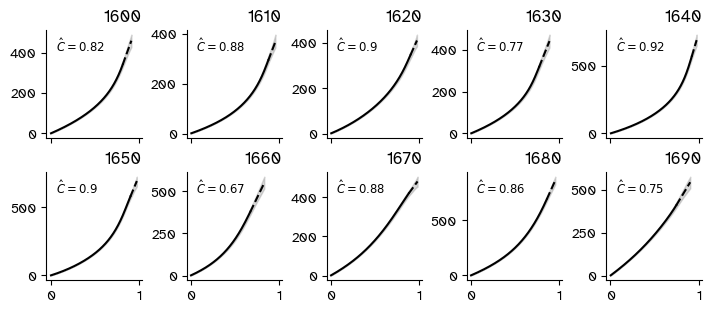

In [48]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(7, 3), sharex=True, constrained_layout=True)
axes = axes.flatten()

for ax in axes:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

ls = 'solid', 'dashed'

for i, decade in enumerate(curves.keys()):
    acc_df = curves[decade]
    estimation = acc_df['est'].values
    interpolated = acc_df['interpolated'].values
    coverage = acc_df['coverage'].values
    lci = acc_df['lci'].values
    uci = acc_df['uci'].values    

    axes[i].plot(coverage[interpolated], estimation[interpolated], color="black", ls="-")
    axes[i].plot(coverage[~interpolated], estimation[~interpolated], color="black", ls="--")
    axes[i].fill_between(coverage, lci, uci, alpha=0.3, color="grey")
    axes[i].set_title(decade, loc="right")
    axes[i].annotate(fr"$\hat{{C}} = {round(coverage[interpolated].max(), 2)}$", xy=(0.1, 0.8), 
                     xycoords="axes fraction", size="small")

# axes[-1].axis('off')
plt.savefig("../images/rarefaction-extrapolation-coverage-diachronic.png", dpi=300)

In [ ]:
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

STYLES = {
    'interpolated': dict(color="black", ls="-"),
    'extrapolated': dict(color="black", ls="--"),
    'confidence': dict(alpha=0.3, color="grey"),
    'reference': dict(ls="-", lw=0.5, color="grey", zorder=-10),
    'label': dict(size="small", color="black", ha="left", va="center")
}

def setup_base_plot(ax, xlabel):
    """Set up basic plot styling"""
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Expected Richness $E(S_m)$")
    return ax

def plot_curve(place, x_values, df, ax):
    """Plot a single diversity curve with confidence intervals"""
    estimation = df['est'].values
    interpolated = df['interpolated'].values
    lci, uci = df['lci'].values, df['uci'].values

    ax.plot(x_values[interpolated], estimation[interpolated], **STYLES['interpolated'])
    ax.plot(x_values[~interpolated], estimation[~interpolated], **STYLES['extrapolated'])
    ax.fill_between(x_values, lci, uci, **STYLES['confidence'])
    ax.text(x_values[-1], estimation[-1], f"   {place}", **STYLES['label'])

def plot_sample_size_diversity(curves, places, ax=None):
    """Plot diversity curves against sample size"""
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 4))
    ax = setup_base_plot(ax, "Sample size")

    smallest_n = min(curves[place].index.max() - 1 for place in places)
    for place in places:
        df = curves[place].iloc[:smallest_n]
        plot_curve(place, df.index, df, ax)
    
    return ax

def plot_coverage_diversity(curves, places, ax=None):
    """Plot diversity curves against coverage"""
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 4))
    ax = setup_base_plot(ax, "Coverage")

    for place in places:
        df = curves[place]
        plot_curve(place, df['coverage'].values, df, ax)
    
    return ax

def add_reference_points(curves, place_a, place_b, x_values, get_estimates_func, ax):
    """Add reference points and ratio annotations to the plot"""
    for x_val in x_values:
        est_a, est_b = get_estimates_func(curves, place_a, place_b, x_val)
        ax.vlines(x=x_val, ymin=0, ymax=est_a, **STYLES['reference'])
        ax.vlines(x=x_val, ymin=est_a, ymax=est_b, **{**STYLES['reference'], 'ls': '--'})
        
        ratio = max(est_a, est_b) / min(est_a, est_b)
        x_offset = 8 if isinstance(x_val, (int, np.integer)) else 0.003
        ax.annotate(f"{ratio:.2f}", (x_val + x_offset, 0), 
                   rotation=90, fontsize='small', va="bottom")

def get_sample_size_estimates(curves, place_a, place_b, sample_size):
    """Get diversity estimates for a given sample size"""
    return (curves[place_a].iloc[sample_size]['est'],
            curves[place_b].iloc[sample_size]['est'])

def get_coverage_estimates(curves, place_a, place_b, target_coverage):
    """Get diversity estimates for a given coverage value"""
    def get_nearest_estimate(place):
        df = curves[place].round(3)
        idx = abs(df["coverage"] - target_coverage).idxmin() - 1
        return df.iloc[idx]["est"]
    
    return (get_nearest_estimate(place_a), get_nearest_estimate(place_b))

def plot_diversity_comparison(curves, place_a, place_b, coverage_offset=0.1):
    """Create complete diversity comparison plots"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
    
    smallest_n = min(df.index.max() - 1 for df in [curves[place_a], curves[place_b]])
    sample_sizes = [int(smallest_n / 3 * i) for i in range(1, 4)]
    
    smallest_c = min(df.loc[df['interpolated'], 'coverage'].max() 
                    for df in [curves[place_a], curves[place_b]])
    max_c = min(df['coverage'].max() for df in [curves[place_a], curves[place_b]])
    coverage_thresholds = np.linspace(
        max(smallest_c - coverage_offset, 0), 
        min(smallest_c + coverage_offset, max_c), num=3)

    plot_sample_size_diversity(curves, [place_a, place_b], ax1)
    plot_coverage_diversity(curves, [place_a, place_b], ax2)
    
    add_reference_points(curves, place_a, place_b, sample_sizes, 
                        get_sample_size_estimates, ax1)
    add_reference_points(curves, place_a, place_b, coverage_thresholds, 
                        get_coverage_estimates, ax2)

    custom_lines = [Line2D([0], [0], **STYLES['interpolated']),
                   Line2D([0], [0], **STYLES['extrapolated'])]
    fig.legend(custom_lines, ["rarefaction", "extrapolation"],
              edgecolor="None", ncol=2,
              loc="upper center", bbox_to_anchor=(0.5, 1.1),
              borderaxespad=0)
    
    return ax1, ax2

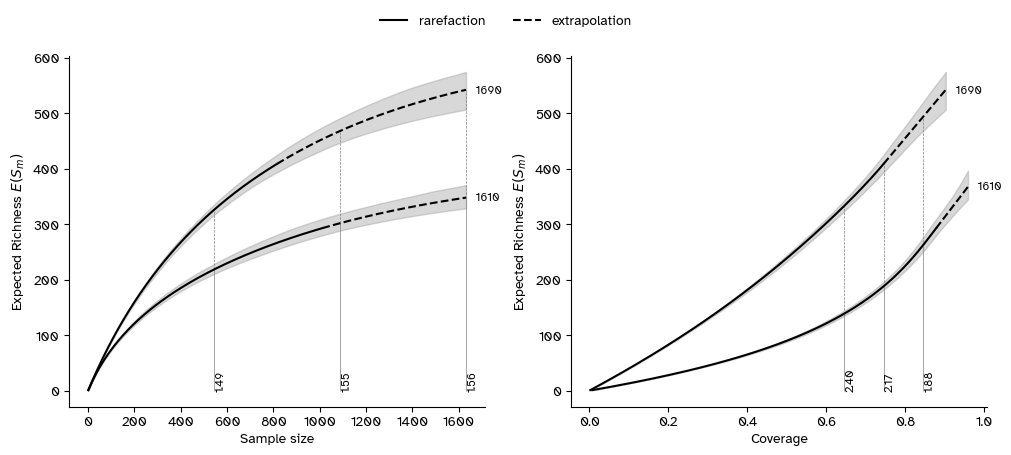

In [50]:
x1, ax2 = plot_diversity_comparison(curves, 1610, 1690)

In [7]:
results = []

min_coverage, min_sample_size = None, None

for decade in curves.keys():
    df = curves[decade]
    df = df[df['interpolated']]
    coverage = df['coverage'].iloc[-1]
    sample_size = df.shape[0] - 1
    if min_coverage is None or coverage < min_coverage:
        min_coverage = coverage
    if min_sample_size is None or sample_size < min_sample_size:
        min_sample_size = sample_size

min_coverage, min_sample_size

for decade in curves.keys():
    df = curves[decade]
    df = df[df['interpolated']]
    idx = abs(df["coverage"] - min_coverage).idxmin() - 1
    mean_coverage_rarified = df.iloc[idx]["est"]
    mean_size_rarified = df.iloc[min_sample_size]["est"]
    raw_richness = datasets[decade].S_obs
    results.append({
        "decade": decade, 
        "sample_size": df.shape[0],
        "coverage": df.iloc[-1]["coverage"],
        'raw_richness': raw_richness,
        'size_rarified_richness': mean_size_rarified.astype(int),
        'coverage_rarified_richness': mean_coverage_rarified.astype(int)
    })

df = pd.DataFrame(results)
df['raw_rank'] = df['raw_richness'].rank(ascending=False)
df['size_rarified_rank'] = df['size_rarified_richness'].rank(ascending=False)
df['coverage_rarified_rank'] = df['coverage_rarified_richness'].rank(ascending=False)

df

,decade,sample_size,coverage,raw_richness,size_rarified_richness,coverage_rarified_richness,raw_rank,size_rarified_rank,coverage_rarified_rank
0,1600,926,0.824164,329,290,199,8.0,8.0,8.0
1,1610,1001,0.878244,291,251,150,10.0,10.0,10.0
2,1620,1236,0.902991,348,280,190,7.0,9.0,9.0
3,1630,778,0.772786,321,308,227,9.0,7.0,7.0
4,1640,2596,0.919137,572,317,242,3.0,6.0,6.0
5,1650,2228,0.902198,581,335,277,2.0,5.0,5.0
6,1660,724,0.674483,378,377,377,6.0,3.0,2.0
7,1670,1190,0.882452,420,340,280,4.0,4.0,4.0
8,1680,2065,0.860116,692,398,417,1.0,1.0,1.0
9,1690,815,0.745098,409,384,353,5.0,2.0,3.0


In [8]:
popsize_df = pd.read_csv("../data/population-estimates.csv")
popsize_df = popsize_df[popsize_df["location"] == "Amsterdam"].drop("location", axis=1)
df = df.merge(popsize_df, left_on="decade", right_on="decade")
df

,decade,sample_size,coverage,raw_richness,size_rarified_richness,coverage_rarified_richness,raw_rank,size_rarified_rank,coverage_rarified_rank,pop_estimate,error
0,1600,926,0.824164,329,290,199,8.0,8.0,8.0,56752.541667,0.046078
1,1610,1001,0.878244,291,251,150,10.0,10.0,10.0,78808.285714,0.043182
2,1620,1236,0.902991,348,280,190,7.0,9.0,9.0,92036.000000,0.043115
3,1630,778,0.772786,321,308,227,9.0,7.0,7.0,127555.315789,0.044154
4,1640,2596,0.919137,572,317,242,3.0,6.0,6.0,142153.555556,0.045614
5,1650,2228,0.902198,581,335,277,2.0,5.0,5.0,172644.950000,0.050008
6,1660,724,0.674483,378,377,377,6.0,3.0,2.0,187175.043478,0.052763
7,1670,1190,0.882452,420,340,280,4.0,4.0,4.0,190929.807692,0.054167
8,1680,2065,0.860116,692,398,417,1.0,1.0,1.0,198540.833333,0.055018
9,1690,815,0.745098,409,384,353,5.0,2.0,3.0,199624.078947,0.056107


In [9]:
def analyze_rank_changes(df):
    """
    Analyze how rankings change between different methods
    """
    rank_changes = pd.DataFrame({
        'collection': df['decade'],
        'raw_to_size': df['raw_rank'] - df['size_rarified_rank'],
        'raw_to_coverage': df['raw_rank'] - df['coverage_rarified_rank'],
        'size_to_coverage': df['size_rarified_rank'] - df['coverage_rarified_rank']
    })
    
    return rank_changes

analyze_rank_changes(df)

,collection,raw_to_size,raw_to_coverage,size_to_coverage
0,1600,0.0,0.0,0.0
1,1610,0.0,0.0,0.0
2,1620,-2.0,-2.0,0.0
3,1630,2.0,2.0,0.0
4,1640,-3.0,-3.0,0.0
5,1650,-3.0,-3.0,0.0
6,1660,3.0,4.0,1.0
7,1670,0.0,0.0,0.0
8,1680,0.0,0.0,0.0
9,1690,3.0,2.0,-1.0


In [10]:
df["se"] = df["pop_estimate"] * (df["error"] / np.sqrt(3))
df["abs_lower"] = df['pop_estimate'] - df["se"]
df["abs_upper"] = df['pop_estimate'] + df["se"]
df

,decade,sample_size,coverage,raw_richness,size_rarified_richness,coverage_rarified_richness,raw_rank,size_rarified_rank,coverage_rarified_rank,pop_estimate,error,se,abs_lower,abs_upper
0,1600,926,0.824164,329,290,199,8.0,8.0,8.0,56752.541667,0.046078,1509.795010,55242.746656,58262.336677
1,1610,1001,0.878244,291,251,150,10.0,10.0,10.0,78808.285714,0.043182,1964.777952,76843.507762,80773.063666
2,1620,1236,0.902991,348,280,190,7.0,9.0,9.0,92036.000000,0.043115,2290.990018,89745.009982,94326.990018
3,1630,778,0.772786,321,308,227,9.0,7.0,7.0,127555.315789,0.044154,3251.697490,124303.618300,130807.013279
4,1640,2596,0.919137,572,317,242,3.0,6.0,6.0,142153.555556,0.045614,3743.635370,138409.920185,145897.190926
5,1650,2228,0.902198,581,335,277,2.0,5.0,5.0,172644.950000,0.050008,4984.640152,167660.309848,177629.590152
6,1660,724,0.674483,378,377,377,6.0,3.0,2.0,187175.043478,0.052763,5701.861054,181473.182424,192876.904532
7,1670,1190,0.882452,420,340,280,4.0,4.0,4.0,190929.807692,0.054167,5970.956484,184958.851208,196900.764176
8,1680,2065,0.860116,692,398,417,1.0,1.0,1.0,198540.833333,0.055018,6306.589440,192234.243893,204847.422774
9,1690,815,0.745098,409,384,353,5.0,2.0,3.0,199624.078947,0.056107,6466.505336,193157.573611,206090.584283


In [ ]:
import pymc as pm

def build_model(y, x_obs, x_se):
    with pm.Model() as model:
        alpha = pm.Normal('alpha', mu=0, sigma=5)
        beta = pm.Normal('beta', mu=0, sigma=1)
        
        x_true = pm.Uniform('x_true', 
                           lower=x_obs - x_se,  # minimum value
                           upper=x_obs + x_se,  # maximum value
                           shape=len(y))        
        
        log_lambda = alpha + beta * pm.math.log(x_true)
        
        y_obs = pm.Poisson('y_obs', mu=pm.math.exp(log_lambda), observed=y)
        
    return model

In [ ]:
def generate_predictions(trace, model, pop_range=None, num_points=100, log_scale=True, quantiles=[0.03, 0.97]):
    posterior = trace.posterior
    
    alpha_samples = posterior['alpha'].values.flatten()
    beta_pop_samples = posterior['beta'].values.flatten()
    
    if pop_range is None:
        pop_range = (1000, 1000000)
        
    if log_scale:
        pop_values = np.logspace(np.log10(pop_range[0]), np.log10(pop_range[1]), num_points)
    else:
        pop_values = np.linspace(pop_range[0], pop_range[1], num_points)
    
    n_samples = len(alpha_samples)
    predictions = np.zeros((n_samples, num_points))
    
    for i in range(n_samples):
        alpha = alpha_samples[i]
        beta_pop = beta_pop_samples[i]
        log_lambda = alpha + beta_pop * np.log(pop_values)
        predictions[i, :] = np.exp(log_lambda)
    
    mean_preds = predictions.mean(axis=0)
    quantile_preds = {}
    for q in quantiles:
        quantile_preds[f"q{int(q*100)}"] = np.quantile(predictions, q, axis=0)
    
    preds_df = pd.DataFrame({
        'pop_estimate': pop_values,
        'estimate': mean_preds
    })
    
    for q, values in quantile_preds.items():
        preds_df[q] = values
    
    preds_df['lower_3.0%'] = preds_df['q3']
    preds_df['upper_97.0%'] = preds_df['q97']
    
    return preds_df

Output()

Output()

[None,
 Text(0.5, 0, 'Population size (log)'),
 Text(0, 0.5, 'Standardized diversity estimate')]

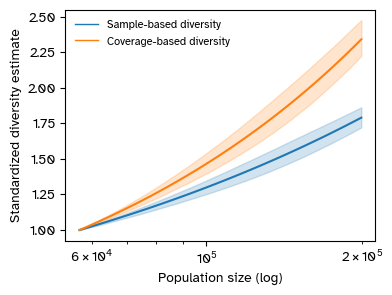

In [13]:
import arviz as az

import logging
logger = logging.getLogger('pymc')
logger.setLevel(logging.ERROR)

fig, ax = plt.subplots(figsize=(4, 3))

for i, variable in enumerate(('raw_richness', 'coverage_rarified_richness')):
    # Create the PyMC model
    model = build_model(df[variable], df['pop_estimate'], df['se'])
    # Fit the model
    with model:
        # Use NUTS sampler (No U-Turn Sampler)
        trace = pm.sample(1000, tune=1000, return_inferencedata=True)

        preds = generate_predictions(
            trace, model, pop_range=(df["pop_estimate"].min(), df["pop_estimate"].max()))

    preds['lci'] = preds['lower_3.0%'] / preds['lower_3.0%'].min()
    preds['uci'] = preds['upper_97.0%'] / preds['upper_97.0%'].min()
    ax.plot(preds['pop_estimate'], preds['estimate'] / preds['estimate'].min(), color=f"C{i}", label=variable)
    ax.fill_between(preds['pop_estimate'], preds['lci'], preds['uci'], alpha=0.2, color=f"C{i}")

custom_lines = [Line2D([0], [0], color=f"C{i}", lw=1) for i in range(2)]
ax.legend(custom_lines, ["Sample-based diversity", "Coverage-based diversity"], 
                        #  bbox_to_anchor=(0.5, 1.05), 
          frameon=False, fontsize=8, columnspacing=0.8)
ax.set(xscale="log", xlabel="Population size (log)", ylabel="Standardized diversity estimate")
# plt.savefig("../images/song-diversity-comparison.png", dpi=300, bbox_inches='tight');

<Axes: >

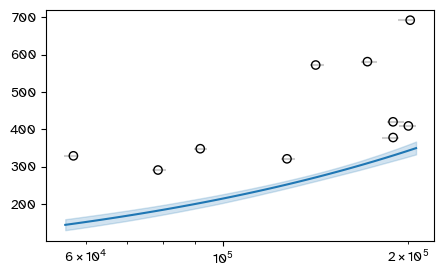

In [ ]:
def plot_enhanced_regression(df, variable, trace, model, color="C0", ylabel=None, figsize=(5, 3), ax=None):
    x_true_posterior = trace.posterior['x_true'].values
    x_true_mean = x_true_posterior.mean(axis=(0, 1))
    x_true_lower = np.percentile(x_true_posterior, 2.5, axis=(0, 1))
    x_true_upper = np.percentile(x_true_posterior, 97.5, axis=(0, 1))
    
    preds = generate_predictions(
        trace, model, pop_range=(min(x_true_lower.min(), df["pop_estimate"].min()), 
                                 max(x_true_upper.max(), df["pop_estimate"].max())))
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    ax.scatter(x_true_mean, df[variable], 
              marker='o', facecolor="none", edgecolor="black", alpha=1,
              zorder=4)
    
    ax.errorbar(df['pop_estimate'], df[variable], 
               xerr=[df['pop_estimate'] - df['abs_lower'], df['abs_upper'] - df['pop_estimate']],
               fmt='o', ecolor='grey', alpha=0.4, capsize=3,
               markerfacecolor='none', markeredgecolor="none", capthick=0, zorder=3)    
    
    preds['lci'] = preds['lower_3.0%']
    preds['uci'] = preds['upper_97.0%']
    ax.plot(preds['pop_estimate'], preds['estimate'], color, 
           label='Regression Line', zorder=2)
    ax.fill_between(preds['pop_estimate'], preds['lci'], preds['uci'], 
                   alpha=0.2, color=color, label='Regression 95% CI', zorder=1)
    ax.set(xscale="log", ylabel=ylabel)
    return ax


# model = build_model(df["raw_richness"], df['pop_estimate'], df['se'])
#     # Fit the model
# with model:
#     # Use NUTS sampler (No U-Turn Sampler)
#     trace = pm.sample(1000, tune=1000, return_inferencedata=True)

plot_enhanced_regression(df, 'raw_richness', trace, model)

Output()

                 mean        sd      hdi_3%     hdi_97%  mcse_mean  mcse_sd  \
alpha           0.584     0.475      -0.310       1.466      0.009    0.007   
beta            0.464     0.040       0.388       0.538      0.001    0.001   
x_true[0]   57034.094   835.759   55583.897   58261.726     10.909    7.714   
x_true[1]   78478.859  1092.931   76845.010   80383.537     14.073    9.990   
x_true[2]   91938.991  1313.763   89763.120   94025.371     17.851   12.647   
x_true[3]  126392.673  1624.821  124304.666  129423.677     23.466   16.643   
x_true[4]  143900.492  1671.182  140641.196  145895.063     23.591   16.682   
x_true[5]  174623.523  2419.510  169912.081  177627.043     37.254   26.344   
x_true[6]  184460.447  2576.594  181473.922  189505.324     37.645   26.804   
x_true[7]  188769.507  3032.827  184963.783  194621.045     41.042   29.179   
x_true[8]  202522.560  2161.619  198433.300  204846.060     31.828   22.507   
x_true[9]  196821.057  3096.664  193158.530  202853.

Output()

                 mean        sd      hdi_3%     hdi_97%  mcse_mean  mcse_sd  \
alpha          -2.432     0.632      -3.663      -1.279      0.011    0.008   
beta            0.677     0.053       0.583       0.783      0.001    0.001   
x_true[0]   57199.361   793.984   55757.056   58261.993     10.945    7.740   
x_true[1]   78467.376  1108.944   76846.892   80387.619     14.696   10.432   
x_true[2]   91887.411  1337.310   89771.792   94069.876     16.839   11.924   
x_true[3]  127121.817  1830.708  124305.400  130230.960     24.237   17.200   
x_true[4]  141543.396  2159.178  138414.374  145242.111     26.638   18.905   
x_true[5]  171591.405  2766.236  167661.257  176501.854     38.722   27.495   
x_true[6]  188825.891  3037.554  183195.617  192876.022     45.626   32.265   
x_true[7]  188905.660  3042.627  184959.347  194710.355     42.269   30.119   
x_true[8]  201413.485  2885.045  195764.347  204847.192     41.512   29.355   
x_true[9]  200073.979  3770.455  194008.715  206089.

/Users/folgert/projects/coverage-complexity/.venv/lib/python3.13/site-packages/matplotlib/text.py:1465: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/folgert/projects/coverage-complexity/.venv/lib/python3.13/site-packages/matplotlib/text.py:1467: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


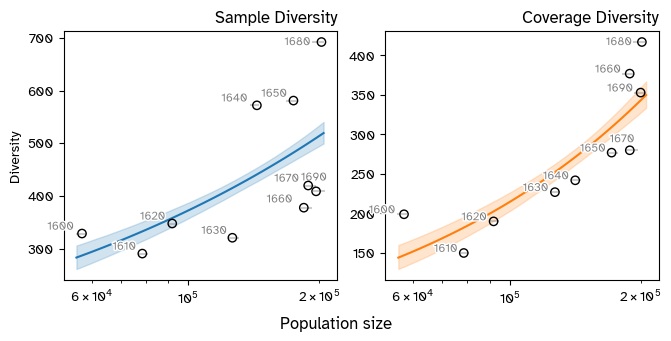

In [18]:
import matplotlib.patheffects as path_effects
import logging

logger = logging.getLogger('pymc')
logger.setLevel(logging.ERROR)

fig, axes = plt.subplots(figsize=(6.6, 3.3), ncols=2, constrained_layout=True)

model_preds = {}
for i, variable in enumerate(('raw_richness', 'coverage_rarified_richness')):
    model = build_model(df[variable], df['pop_estimate'], df['se'])
    # Fit the model
    with model:
        # Use NUTS sampler (No U-Turn Sampler)
        trace = pm.sample(1000, tune=1000, return_inferencedata=True)
    print(az.summary(trace))
    preds = generate_predictions(
        trace, model, pop_range=(df["pop_estimate"].min(), df["pop_estimate"].max()))
    model_preds[variable] = (preds, model, trace)

#     preds['lci'] = preds['lower_3.0%'] / preds['lower_3.0%'].min()
#     preds['uci'] = preds['upper_97.0%'] / preds['upper_97.0%'].min()
#     axes[2].plot(preds['pop_estimate'], preds['estimate'] / preds['estimate'].min(), color=f"C{i}", label=variable)
#     axes[2].fill_between(preds['pop_estimate'], preds['lci'], preds['uci'], alpha=0.2, color=f"C{i}")

# custom_lines = [Line2D([0], [0], color=f"C{i}", lw=1) for i in range(2)]
# axes[2].legend(custom_lines, ["Sample-based diversity", "Coverage-based diversity"], 
#                         #  bbox_to_anchor=(0.5, 1.05), 
#           frameon=False, fontsize=8, columnspacing=0.8)
# axes[2].set(xscale="log")
# axes[2].set_title("Standardized diversity", fontsize=10, loc="right")

to_annotate = range(1600, 1700, 10)

preds, model, trace = model_preds['raw_richness']
plot_enhanced_regression(df, 'raw_richness', trace, model, ax=axes[0])

for place in to_annotate:
    row = df[df['decade'] == place]
    x, y = (-5, 5)
    if place == 1690:
        x, y = (6, 10)
    elif place == 1670:
        x, y = -8, 5
    elif place == 1650:
        x, y = (-3, 5)
    elif place == 1680:
        x, y = -5, 0
    elif place == 1660:
        x, y = -10, 6
    text = axes[0].annotate(
            place, 
            (row['pop_estimate'], row['raw_richness']), 
            xycoords="data",
            xytext=(x, y),
            textcoords="offset points",
            ha="right",
            va="center",
            color="grey",
            size="small")

    text.set_path_effects(
        [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()])

axes[0].set(xscale="log", ylabel="Diversity")
axes[0].set_title("Sample Diversity", fontsize=12, loc="right")

preds, model, trace = model_preds['coverage_rarified_richness']
plot_enhanced_regression(df, 'coverage_rarified_richness', trace, model, ax=axes[1], color="C1")

for place in to_annotate:
    row = df[df['decade'] == place]
    x, y = (-5, 3)
    if place == 1670:
        x, y = 2, 8
    if place == 1680:
        x, y = -5, 0
    text = axes[1].annotate(
            place, 
            (row['pop_estimate'], row['coverage_rarified_richness']), 
            xycoords="data",
            xytext=(x, y),
            textcoords="offset points",
            ha="right",
            va="center",
            color="grey",
            size="small",
            # arrowprops=dict(
            #     arrowstyle="->", shrinkA=0, shrinkB=5, color="black", linewidth=0.75)
            )

    text.set_path_effects(
        [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()])
    # text.arrow_patch.set_path_effects(
    #     [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()])

axes[1].set(xscale="log")
axes[1].set_title("Coverage Diversity", fontsize=12, loc="right")
fig.supxlabel("Population size")
plt.savefig("../images/regression-song-panel-diachronic-pop-error2.png", dpi=300, bbox_inches='tight');